## * 数据预处理。
## *  对数据进行分别进行词袋技术BOW、TF—IDF、词向量word2vec技术。

## 1 数据预处理

### 1 引入所需库

In [1]:
import re
import string
import numpy as np
import pandas as pd

import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.graph_objects as go

from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

### 2 使用pandas导入数据

In [2]:
data = pd.read_csv("./input_data/kindle_review.csv")
df = data

### 3 查看数据基本信息

In [3]:
data.shape

(12000, 4)

In [4]:
data.head()

,Unnamed: 0,rating,reviewText,summary
0,0,5,This book was the very first bookmobile book I...,50 + years ago...
1,1,1,"When I read the description for this book, I c...",Boring! Boring! Boring!
2,2,5,I just had to edit this review. This book is a...,Wiggleliscious/new toy ready/!!
3,3,5,I don't normally buy 'mystery' novels because ...,Very good read.
4,4,5,"This isn't the kind of book I normally read, a...",Great Story!


In [5]:
data.summary[0]

'50 + years ago...'

In [6]:
data.reviewText[0]

'This book was the very first bookmobile book I bought when I was in the school book club. I loved the story then and I bet a dollar to a donut I will love it again. If my memory serves, I bought this book in 5th grade. That would have been about 1961. I am looking forward to reliving the memories.'

In [7]:
# 查看缺失值
data.isnull().sum()

Unnamed: 0    0
rating        0
reviewText    0
summary       0
dtype: int64

In [8]:
a=data.rating.value_counts()
fig = go.Figure([go.Bar(x=a.index, y=a.values,text=a.values)])
fig.update_layout(title='Distribution of the Rating using ploty')
fig.show()

### 4 数据清洗

In [9]:
data.columns

Index(['Unnamed: 0', 'rating', 'reviewText', 'summary'], dtype='object')

In [10]:
data = data.drop(['Unnamed: 0', 'summary'], axis=1)

In [11]:
data.head()

,rating,reviewText
0,5,This book was the very first bookmobile book I...
1,1,"When I read the description for this book, I c..."
2,5,I just had to edit this review. This book is a...
3,5,I don't normally buy 'mystery' novels because ...
4,5,"This isn't the kind of book I normally read, a..."


### 5 数据规范化

#### 1 将1-5分映射到0-1值，其中0代表正向而1代表负向

In [12]:
data["rating"] = data["rating"].apply(lambda x: 1 if x < 3  else 0)
data

,rating,reviewText
0,0,This book was the very first bookmobile book I...
1,1,"When I read the description for this book, I c..."
2,0,I just had to edit this review. This book is a...
3,0,I don't normally buy 'mystery' novels because ...
4,0,"This isn't the kind of book I normally read, a..."
...,...,...
11995,1,Had to read certain passages twice--typos. Wi...
11996,0,Not what i expected. yet a very interesting bo...
11997,0,Dragon Knights is a world where Knights ride d...
11998,0,"Since this story is very short, it's hard to s..."


#### 2 将reviewText的英文评价都改为小写

In [13]:
data["reviewText"] = data["reviewText"].str.lower()
data.head()

,rating,reviewText
0,0,this book was the very first bookmobile book i...
1,1,"when i read the description for this book, i c..."
2,0,i just had to edit this review. this book is a...
3,0,i don't normally buy 'mystery' novels because ...
4,0,"this isn't the kind of book i normally read, a..."


#### 3 去除标点符号

In [14]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

data["reviewText"] = data["reviewText"].apply(lambda text: remove_punctuation(text))
data.head()

,rating,reviewText
0,0,this book was the very first bookmobile book i...
1,1,when i read the description for this book i co...
2,0,i just had to edit this review this book is an...
3,0,i dont normally buy mystery novels because i j...
4,0,this isnt the kind of book i normally read alt...


#### 3 调用nltk库，去除书评中无意义的stopwords

In [15]:
# 此处手动安装 C:\Users\Admin\anaconda3\envs\tensorbase 下自建一个nltk_data，里面copora装入解压好的下面两个包
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger')

In [16]:
#removing stop words from the dataset

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

data["reviewText"] = data["reviewText"].apply(lambda text: remove_stopwords(text))
data.head()

,rating,reviewText
0,0,book first bookmobile book bought school book ...
1,1,read description book couldnt wait read downlo...
2,0,edit review book believe got right updated rew...
3,0,dont normally buy mystery novels dont like how...
4,0,isnt kind book normally read although try limi...


#### 4 标注词性留下具有实际意义的词

In [17]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

data["reviewText"] = data["reviewText"].apply(lambda text: lemmatize_words(text))
data.head()

,rating,reviewText
0,0,book first bookmobile book buy school book clu...
1,1,read description book couldnt wait read downlo...
2,0,edit review book believe get right update rewr...
3,0,dont normally buy mystery novels dont like how...
4,0,isnt kind book normally read although try limi...


### 6 统计数据

In [18]:
a  = data.rating.value_counts()
fig = go.Figure([go.Bar(x=a.index, y=a.values,text=a.values)])
fig.update_layout(title='Distribution of the Rating using ploty')
fig.show()

#### 1 统计词云

In [19]:
import os
for dirname, _, filenames in os.walk('./ttf'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./ttf\arial.ttf
./ttf\Gothic.ttf
./ttf\msyh.ttc


In [20]:
import matplotlib.colors as colors
text = " ".join(cat.split()[0] for cat in data.reviewText)
#word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
colormaps = colors.ListedColormap(['#868C4E','#A8B092','#B3B59C'])
word_cloud = WordCloud(colormap=colormaps,font_path="./ttf/msyh.ttc",background_color='#F5F3F2').generate(text)

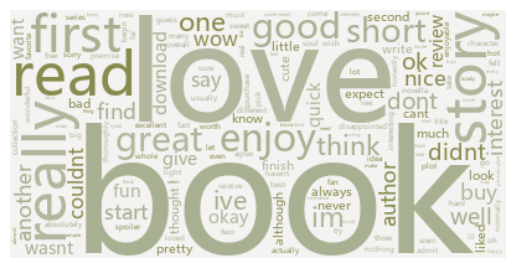

In [21]:
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 2 统计最频繁词

In [22]:
from collections import Counter
cnt = Counter()
for text in data["reviewText"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('book', 15397),
 ('story', 11027),
 ('read', 10023),
 ('like', 6207),
 ('one', 5949),
 ('character', 5677),
 ('get', 5453),
 ('love', 5059),
 ('good', 4763),
 ('would', 4093)]

In [23]:
# 频繁词以kv存储
cnt.get("book")

15397

In [24]:
cn = cnt.most_common(10)
w = []
c = []
for i in cn:
    w.append(i[0])
    c.append(i[1])

In [25]:
fig = px.pie(data, values=c, names=w, color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title="Most Frequent Words")
fig.show()

#### 3 统计最罕见词

In [26]:
n_rare_words = 11
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
RAREWORDS

{'1922',
 'backgroung',
 'don8216t',
 'firedrake',
 'gryphon',
 'helos',
 'insite',
 'meaness',
 'relm',
 'symbols',
 'twicetypos'}

In [51]:
# 添加单词数量
data['word_count'] = data['reviewText'].apply(lambda x: len(str(x).split()))
data.head()

,rating,reviewText,word_count
0,0,book first bookmobile book buy school book clu...,26
1,1,read description book couldnt wait read downlo...,181
2,0,edit review book believe get right update rewr...,238
3,0,dont normally buy mystery novels dont like how...,34
4,0,isnt kind book normally read although try limi...,40


In [54]:
# 查看单词数在40一下的数量
len(data['word_count'][data['word_count'] <= 40])

7067

In [56]:
# 我们只保留单词数在40一下的数据
data = data[:][data['word_count'] <= 40]
data.head()

,rating,reviewText,word_count
0,0,book first bookmobile book buy school book clu...,26
3,0,dont normally buy mystery novels dont like how...,34
4,0,isnt kind book normally read although try limi...,40
7,0,book thoroughly enjoy begin end story line ful...,35
12,0,love paper great writer cancel subscription du...,35


### 7 划分数据集

In [64]:
data

,rating,reviewText,word_count
0,0,book first bookmobile book buy school book clu...,26
3,0,dont normally buy mystery novels dont like how...,34
4,0,isnt kind book normally read although try limi...,40
7,0,book thoroughly enjoy begin end story line ful...,35
12,0,love paper great writer cancel subscription du...,35
...,...,...,...
11995,1,read certain passage twicetypos wish build rel...,10
11996,0,expect yet interesting book usually don8216t r...,12
11997,0,dragon knight world knight ride dragon slay wi...,29
11998,0,since story short hard say much without give a...,28


In [29]:
xtrain, xtest, ytrain, ytest = train_test_split(data['reviewText'], data['rating'], test_size = 0.3)

### 8 三种技术完成单词向量化

#### 1 词袋技术BOW

In [31]:
# 通过BOW将词向量化，将文本转化为0-1向量
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

xtrain_bow = vectorizer.fit_transform(xtrain).toarray()
xtest_bow = vectorizer.transform(xtest).toarray()

#### 2 TF-IDF

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer  

tf_vectorizer = TfidfVectorizer()

xtrain_tf = tf_vectorizer.fit_transform(xtrain).toarray()
xtest_tf = tf_vectorizer.transform(xtest).toarray()

#### 3 word2vec 静态词向量

In [57]:
# 构建单词向量
from gensim.models import word2vec
# 需要先切词，将字符串切分为一个个单词
def splitWords(raw_sentence_list):
    sen_list = []
    for item in raw_sentence_list:
        item = item.split()
        sen_list.append(item)
    return sen_list 

sen_list = splitWords(data['reviewText'])
wv_model = word2vec.Word2Vec(sen_list, vector_size=100)

In [58]:
# 查看向量规模
wv_model.wv.vectors.shape

(2612, 100)

In [59]:
# 查看最相似的词
wv_model.wv.most_similar('book')

[('read', 0.9897429943084717),
 ('series', 0.9896576404571533),
 ('buy', 0.9893274903297424),
 ('first', 0.9853489995002747),
 ('ive', 0.9848994612693787),
 ('put', 0.9819313287734985),
 ('one', 0.9818368554115295),
 ('author', 0.9800581932067871),
 ('rest', 0.9799580574035645),
 ('forward', 0.977293074131012)]

In [60]:
def fun(sen_list,wv_model):
    word_set = set(wv_model.wv.index_to_key)
    X = np.zeros([len(sen_list),40,100])
    c = 0
    for sen in sen_list:
        nw=39
        for w in list(reversed(sen)):
            if w in word_set:
                X[c,nw] = wv_model.wv[w]
                nw=nw-1
        c=c+1
    return X

X = fun(sen_list,wv_model)

In [61]:
# 切分数据集
y = data['rating'].values
xtrain_vec, xtest_vec, ytrain_vec, ytest_vec = train_test_split(X, y, test_size = 0.3)

In [62]:
xtrain_vec.shape

(5014, 40, 100)

### 9 导出处理后的数据

In [76]:
xtrain_tf.shape

(8400, 33198)

In [33]:
# 存放为二进制文件，写入很快，但是数量依然很大几个G,上传库时忽略，需要时再生成，自己生成一份留在本地即可
np.save("./processed_data/xtrain_bow.npy", xtrain_bow)
np.save('./processed_data/xtest_bow.npy', xtest_bow)

In [83]:
np.save('./processed_data/xtrain_tf.npy', xtrain_tf)
np.save('./processed_data/xtest_tf.npy', xtest_tf)

In [84]:
np.save('./processed_data/xtrain_vec.npy', xtrain_vec)
np.save('./processed_data/xtest_vec.npy', xtest_vec)